In [23]:
import numpy as np
from numpy.random import Generator, PCG64
import math
from heateq import Exact, Simulateur
import matplotlib.pyplot as plt

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

In [3]:
# Permet d'obtenir un n-échantillon du vecteur aléatoire d'entrée X
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [4]:
# Simulateurs haute et basse fidélité
f = Simulateur(21, 100)
g = Simulateur(3, 20)

In [5]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu
print(mu_exact)

# Espérance exacte de Y = f(X) (solution discrétisée, haute fidélité)
mu_Y_exact = f.mu
print(mu_Y_exact)

# Espérance exacte de Z = g(X) (solution discrétisée, basse fidélité)
mu_Z_exact = g.mu
print(mu_Z_exact)

41.98447216482205
41.916465294707976
33.03617206344313


# Espérance $\mu_Z$ inconnue

On considère que $\mu_Z$ n'est pas connue.

## Expérience pilote

Estimer $\alpha^*$, $\rho^2$ et $\tau^*$ à l'aide de `ns = 10000` échantillons pilotes, et en déduire une estimation de $\beta=(1+w \tau^*)^2(1-\rho^2)$ (rapport de variance) dans le cas où $\mu_Z$ est inconnue et comparer à $\beta=(1+w)(1-\rho^2)$ dans le cas où $\mu_Z$ est connue (on suppose $w=1/35$).

In [31]:
ns = 10000 # échantillons pilotes
X = n_echantillon_X(ns)

Y = f(X)
Z = g(X)
w=1/35

rho2 = np.cov(Y, Z)[0,1]**2/(np.var(Z)*np.var(Y))
tau_star = np.sqrt(rho2/(w*(1-rho2)))
alpha_star = (1-1/tau_star)*np.cov(Y, Z)[0,1]/np.var(Z)
beta = (1+w*tau_star)**2*(1-rho2)
beta_connue = (1+w)*(1-rho2)

print("alpha", alpha_star)
print("rho2", rho2)
print("tau",tau_star)
print("beta",beta)
print("beta connue", beta_connue)

alpha 0.9806026638360373
rho2 0.9821017030039207
tau 43.82343332026833
beta 0.09077919279356489
beta connue 0.018409676910252946


## Estimateur ACV

Utiliser la valeur de $\alpha^*$ estimée précédemment (avec des échantillons pilotes) pour contruire un estimateur par variable de contrôle pour l'espérance de $Y$. 
Faire `nr = 1000` répétitions pour des budgets (en termes de nombre d'évaluations haute fidélité équivalentes) $\tilde{n}_f = c / c_f \in \{5; 10; 20; 50; 100; 200; 500; 1000\}$.

Estimer la réduction de variance à budget équivalent entre l'estimateur par variable de contrôle et l'estimateur Monte Carlo classique (haute fidélité). Est-elle conforme à la valeur de $\beta$ calculée précédemment ?

Tracer l'espérance et l'écart-type (sous forme de barres d'erreur) des estimateurs par variable de contrôle et Monte Carlo (haute fidélité) à budget équivalent en fonction de $\tilde{n}_f$. Sur un autre graphe, tracer l'évolution de la REQM des estimateurs en fonction de $\tilde{n}_f$.

In [41]:
nr = 1000
budgets = [5, 10, 20, 50, 100, 200, 500, 1000]

esperances_haute = []
esperances_haute_nr = []
var_haute = []
var_haute_nr = []
betas = []
betas_real = []
betas_real_mean = []
betas_final_estim = []
RMSE_estim = []
RMSE_hf = []

for n_tilde in budgets:
    moy_emp_Y = []
    Y_estim_nr = []
    betas_real = []
    betas_estimations = []
    
    for i in range(nr):
        X = n_echantillon_X(n_tilde)
        Y = f(X)
        Z = g(X)
        
        n_star = math.floor(n_tilde/(1+tau_star*w))
        N_star = math.floor(tau_star-1)*n_star
        
        beta_estim = (1+w*tau_star)**2*(1-rho2)
        betas_estimations.append(beta_estim)
        
        X_estim = n_echantillon_X(N_star)
        Z_estim = g(X_estim)
        mu_estim = np.mean(Z_estim)
        
        # betas_estimations.append((1+w*tau_star)**2*(1-rho2))

        Y_estim = np.mean(Y) - alpha_star*(np.mean(Z) - mu_estim)
        Y_estim_nr.append(Y_estim)
        
        Xf = n_echantillon_X(n_star)
        moy_emp_Y.append(np.mean(f(Xf)))

        

    esp_h = np.mean(moy_emp_Y)
    esp_h_nr = np.mean(Y_estim_nr)
    var_h = np.var(moy_emp_Y)
    var_h_nr = np.var(Y_estim_nr)
    esp_beta_estim = np.mean(betas_estimations)

    rmse_y_estim = np.sqrt(np.mean((esp_h_nr - mu_exact) ** 2) + np.var(esp_h_nr))
    rmse_y_hf = np.sqrt(np.mean((esp_h - mu_exact) ** 2) + np.var(esp_h))

    RMSE_estim.append(rmse_y_estim)
    RMSE_hf.append(rmse_y_hf)
    betas_final_estim.append(esp_beta_estim)
    esperances_haute.append(esp_h)
    esperances_haute_nr.append(esp_h_nr)       
    var_haute.append(var_h)
    var_haute_nr.append(var_h_nr)
    betas_real_mean.append(var_h_nr/var_h)

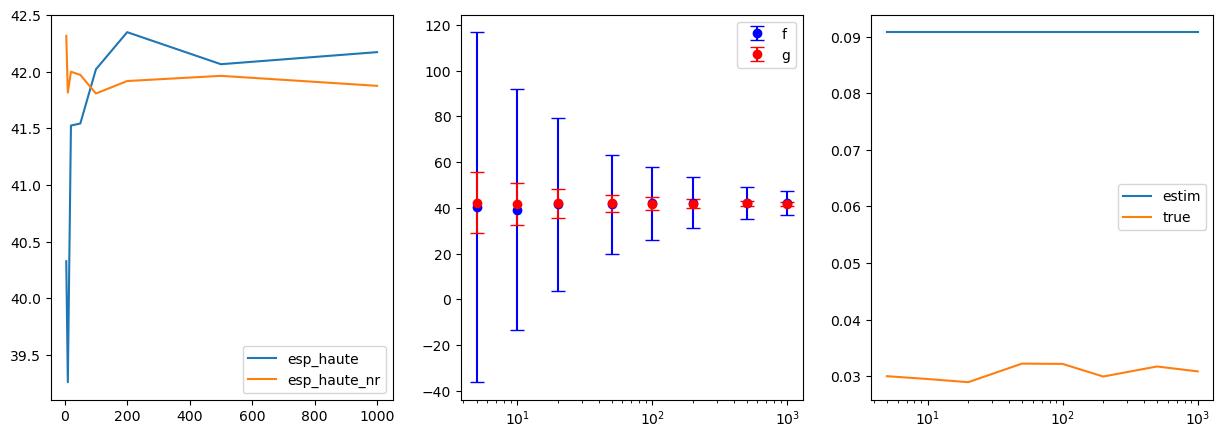

In [42]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].plot(budgets,esperances_haute, label="esp_haute")
axs[0].plot(budgets,esperances_haute_nr, label="esp_haute_nr")

axs[1].errorbar(budgets, esperances_haute, yerr=np.sqrt(var_haute), fmt="o", color="b", capsize=5, label="f")
axs[1].errorbar(budgets, esperances_haute_nr, yerr=np.sqrt(var_haute_nr), fmt="o", color="r", capsize=5, label="g")

axs[2].plot(budgets, betas_final_estim, label="estim")
axs[2].plot(budgets, betas_real_mean, label="true")
                       
for ax in axs:
    if ax!=axs[0] :
        ax.set_xscale("log")
    ax.legend()
plt.show()

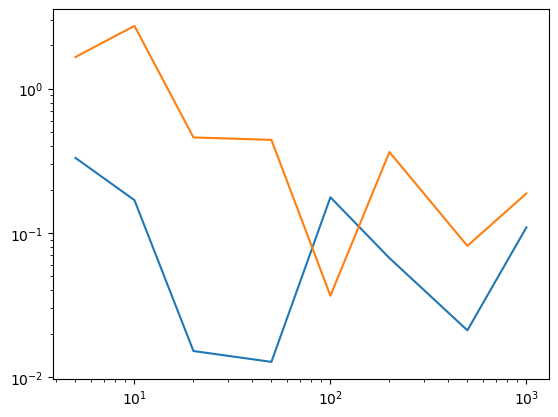

In [45]:
plt.plot(budgets, RMSE_estim, label="rmse_haute")
plt.plot(budgets, RMSE_hf, label="rmse_basse")
plt.xscale("log")
plt.yscale("log")